### Домашнее задание N5

In [626]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [627]:
# датасет 100 объектов и 2 признака
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

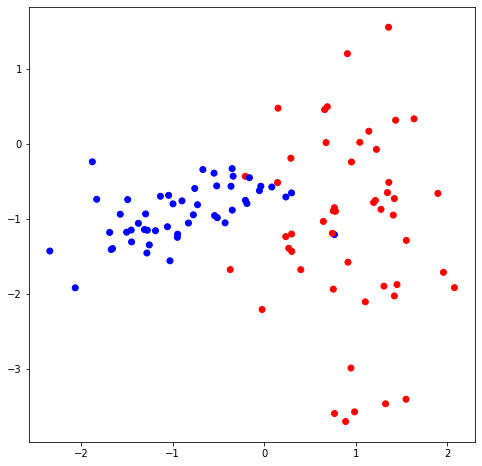

In [628]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [629]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    #--------------------------------------------------------------------------------------------------------------
    # массив всех индексов выборки
    all_index = [x for x in range(n_samples)]
    #--------------------------------------------------------------------------------------------------------------
    
    for i in range(N):
    
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        #--------------------------------------------------------------------------------------------------------------
        # Out Of Bag данные
        # индексы объектов, не вошедших в выборку
        oob_index = [x for x in all_index if x not in sample_index]
        
        # OOB - сами данные и ответы
        oob_data   = data[oob_index]
        oob_labels = labels[oob_index]
        #--------------------------------------------------------------------------------------------------------------
        # кроме основной выборки, добавлены OOB данные и ответы
        bootstrap.append((b_data, b_labels, oob_data, oob_labels))
        #--------------------------------------------------------------------------------------------------------------
    
    return bootstrap

In [630]:
# get_bootstrap(classification_data, classification_labels, 1)

In [631]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [632]:
# get_subsample(16)

In [633]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [634]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [635]:
#--------------------------------------------------------------------------------------------------
# Функция расчета критерия Джини и Энтропии Шеннона
#--------------------------------------------------------------------------------------------------

def crit_inform(labels):
    
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #--------------------------------------------------------------------------------------------------
    #  расчет критерия
    global criterion_inform                         # глобальная переменная; определяет критерий информативности
    
    impurity = 0
    #--------------------------------------------------------------------------------------------------
    if criterion_inform == 'gini':                  # критерий Джини
        
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    #--------------------------------------------------------------------------------------------------
    elif criterion_inform == 'entropy':             # энтропия Шеннона
       
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            if p != 0: 
                impurity += p * np.log2(p)
                
        impurity = -impurity
    #--------------------------------------------------------------------------------------------------
    
    return impurity 

In [636]:
# Расчет прироста

def gain(left_labels, right_labels, root_crit_inf):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_crit_inf - p * crit_inform(left_labels) - (1 - p) * crit_inform(right_labels)

In [637]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [638]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

#---------------------------------------------------------------------------
# замена функции критерия информативности
#     root_gini = gini(labels)
    root_crit_inf = crit_inform(labels)
#---------------------------------------------------------------------------

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indixes = get_subsample(n_features)             # выбираем случайные признаки
    
    for index in feature_subsample_indixes:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue

#-------------------------------------------------------------------------------------------------
#             current_gain = gain(true_labels, false_labels, root_gini)
            current_gain = gain(true_labels, false_labels, root_crit_inf)
#-------------------------------------------------------------------------------------------------
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [639]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [640]:
#------------------------------------------------------------------------------------------------------------
# массив для сбора OOB данных
oob_data_test = []

In [641]:
#------------------------------------------------------------------------------------------------------------
# добавлен параметр oob_data_test - OOB данные 
def random_forest(data, labels, n_trees, oob_data_test = []):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    step = 0
    #------------------------------------------------------------------------------------------------------------
    # добавлены массивы OOB данные и ответы
    for b_data, b_labels, oob_data, oob_labels in bootstrap:

        forest.append(build_tree(b_data, b_labels))
        
        #------------------------------------------------------------------------------------------------------------
        # наполнение массива OOB данными
        oob_data_test.append([oob_data, oob_labels])
        
    return forest

In [642]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [643]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [644]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [645]:
# tree_vote(my_forest_3, test_data[:5])

In [646]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [647]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [648]:
#----------------------------------------------------------------------------------------------
# Функция подсчета точности для Out Of Bag данных
#----------------------------------------------------------------------------------------------

def accuracy_metric_oob(forest, oob_data):

    # добавим предсказания всех деревьев в список
    predictions = []
    answears = []
    for i, tree in enumerate(forest):

        data = oob_data[i][0]
        answears.append(list(np.squeeze(oob_data[i][1])))
        predictions.append(predict(data, tree))
    
    print('\nПредсказания =', predictions)
    print('\nОтветы       =', answears)

    accuracy = []
    for i, pred in enumerate(predictions):
        print(f'\nДерево {i}; Объекты, на которых не обучалось дерево: ')
        true_value = 0
        
        for j, pred_value in enumerate(pred):
        
            err = ''
            fact_value = answears[i][j]
            if (pred_value == fact_value):
                true_value += 1
            else:
                err = 1
            print(f'\tpred = {pred_value}; fact = {fact_value}; err = {err}')
        
        accuracy_i = round(true_value / len(pred), 4)
        accuracy.append(accuracy_i)
        print(f'Средняя точность = {accuracy_i}')
    
    # итоговая средняя точность
    mean_accuracy = np.mean(accuracy)
    
    print()
    print(f'Точность по всем деревьям = {accuracy}')
    print(f'Итоговая средняя точность = {round(mean_accuracy, 4)}')
    
    return mean_accuracy

### Задание 1

#### Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [649]:
# Визуализация
def get_meshgrid(data, step=.05, border=1.2):
    x_min = data[:, 0].min() - border
    x_max = data[:, 0].max() + border
    
    y_min = data[:, 1].min() - border
    y_max = data[:, 1].max() + border
    
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize(train_data, test_data, my_tree):

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    
    xx, yy = get_meshgrid(train_data)
    ## функция tree_vote
    mesh_predictions = np.array(tree_vote(my_tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    plt.title(f'{len(my_tree)} trees; Train accuracy={train_accuracy:.2f}', fontsize = 14, weight = 'bold')

    # график тестовой выборки
    plt.subplot(1,2,2)
    
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    plt.title(f'{len(my_tree)} trees; Test accuracy={test_accuracy:.2f}', fontsize = 14, weight = 'bold')

#### Четыре варианта случайного леса

In [650]:
# задаю критерий информативности
criterion_inform = 'gini'

In [651]:
oob_data_test = []


Случайный лес из 1 деревьев:
	Точность на обучающей выборке: 88.571
	Точность на тестовой выборке:  73.333

Случайный лес из 3 деревьев:
	Точность на обучающей выборке: 91.429
	Точность на тестовой выборке:  83.333

Случайный лес из 10 деревьев:
	Точность на обучающей выборке: 95.714
	Точность на тестовой выборке:  90.000

Случайный лес из 50 деревьев:
	Точность на обучающей выборке: 95.714
	Точность на тестовой выборке:  86.667
Wall time: 8.75 s


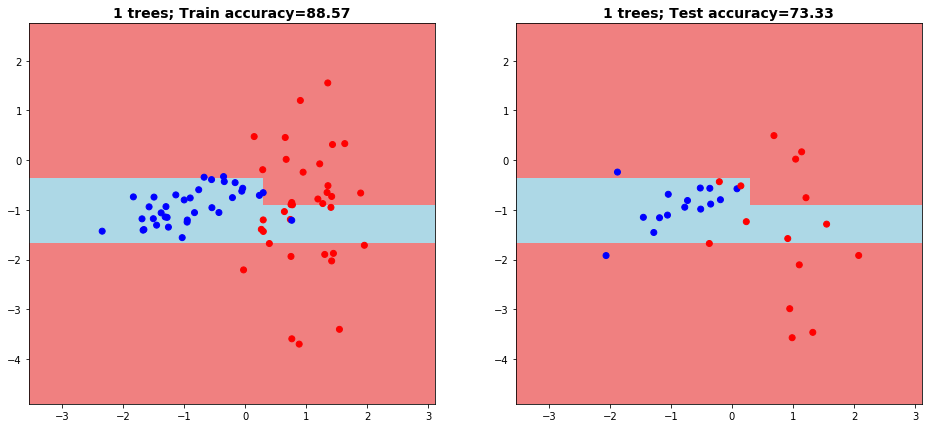

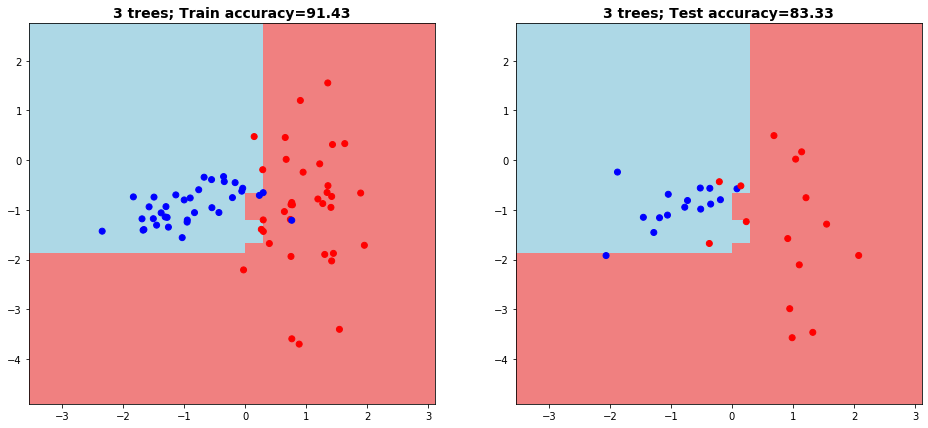

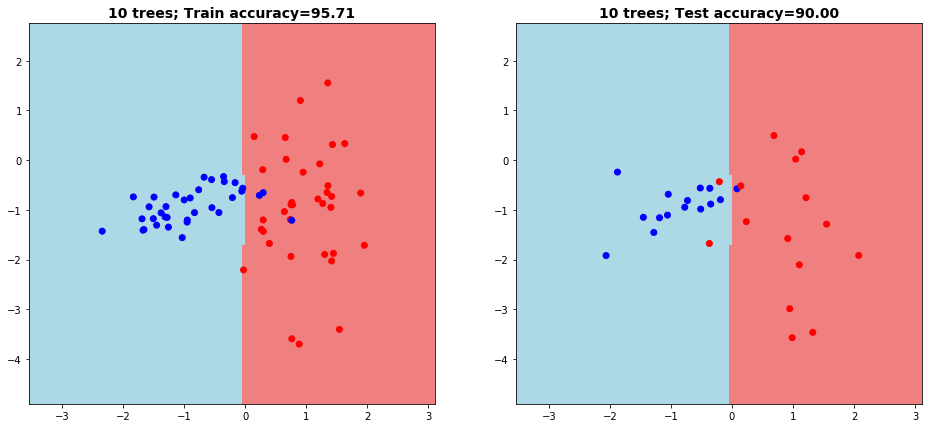

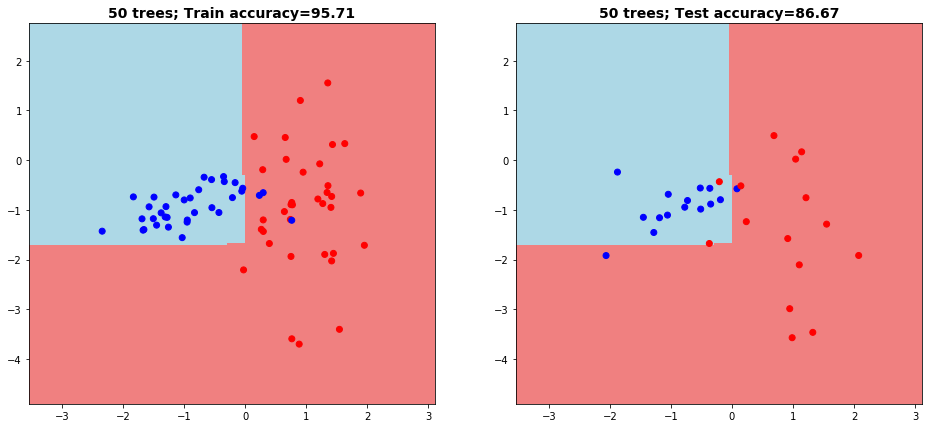

In [652]:
%%time
import time
count_trees = [1, 3, 10, 50]

for n_trees in count_trees:

    current_forest = random_forest(train_data, train_labels, n_trees)

    # ответы для обучающей выборки и тестовой выборок
    train_answers = tree_vote(current_forest, train_data)
    test_answers  = tree_vote(current_forest, test_data)

    # точность на обучающей и тестовой выборках
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy  = accuracy_metric(test_labels, test_answers)

    print(f'\nСлучайный лес из {n_trees} деревьев:')
    print(f'\tТочность на обучающей выборке: {train_accuracy:.3f}')
    print(f'\tТочность на тестовой выборке:  {test_accuracy:.3f}')
    time.sleep(1)
    
    visualize(train_data, test_data, current_forest)


### Задание 2

#### Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

В целом, с увеличением числа деревьев сложность гиперплоскости увеличивается.
Для леса с одним деревом на разных датасетах периодичестки было заметно недообучение.
Переобучение не наблюдалось.

### Задание 3

#### *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

На примере леса из трех деревьев оцениваю качество модели с помощью OOB данных

In [653]:
oob_data_test = []
n_trees = 3
current_forest = random_forest(train_data, train_labels, n_trees, oob_data_test)

train_answers = tree_vote(current_forest, train_data)

print(f'\nСлучайный лес из {n_trees} деревьев:')

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'\tТочность на обучающей выборке: {train_accuracy:.3f}')
print()
accuracy = accuracy_metric_oob(current_forest, oob_data_test)


Случайный лес из 3 деревьев:
	Точность на обучающей выборке: 94.286


Предсказания = [[1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]]

Ответы       = [[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]]

Дерево 0; Объекты, на которых не обучалось дерево: 
	pred = 1; fact = 1; err = 
	pred = 1; fact = 1; err = 
	pred = 1; fact = 1; err = 
	pred = 1; fact = 1; err = 
	pred = 0; fact = 0; err = 
	pred = 1; fact = 1; err = 
	pred = 1; fact = 0; err = 1
	pred = 0; fact = 0; err = 
	pred = 0; fact = 0; err = 
	pred = 0; fact = 1; err = 1
	pred = 0; fact = 0; err = 
	pred = 1; fact = 1; err = 
	pred = 1; fact = 0; err = 1
	pred = 0; fac

### Задание 4

#### *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

Исходная функция gini заменена на функцию crit_inform

Введена глобальная переменная criterion_inform, которая определяет критерий информативности при построении дерева

Для проверки строится случайный лес (как в задании 1), с таким же количеством деревьев, но с новым критерием информативности

In [654]:
criterion_inform = 'entropy'

In [655]:
%%time
import time
count_trees = [1, 3, 10, 50]

for n_trees in count_trees:

    current_forest = random_forest(train_data, train_labels, n_trees)

    # ответы для обучающей выборки и тестовой выборок
    train_answers = tree_vote(current_forest, train_data)
    test_answers  = tree_vote(current_forest, test_data)

    # точность на обучающей и тестовой выборках
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy  = accuracy_metric(test_labels, test_answers)

    print(f'\nСлучайный лес из {n_trees} деревьев:')
    print(f'\tТочность на обучающей выборке: {train_accuracy:.3f}')
    print(f'\tТочность на тестовой выборке:  {test_accuracy:.3f}')
    time.sleep(1)
    
#     visualize(train_data, test_data, current_forest)



Случайный лес из 1 деревьев:
	Точность на обучающей выборке: 92.857
	Точность на тестовой выборке:  86.667

Случайный лес из 3 деревьев:
	Точность на обучающей выборке: 95.714
	Точность на тестовой выборке:  90.000

Случайный лес из 10 деревьев:
	Точность на обучающей выборке: 97.143
	Точность на тестовой выборке:  86.667

Случайный лес из 50 деревьев:
	Точность на обучающей выборке: 95.714
	Точность на тестовой выборке:  90.000
Wall time: 4.57 s
